## ENGG1003 Digital Literacy and Computational Thinking - P
#
### Course Project
#

In [48]:
## Remarks: The program can be run on Anaconda using python 3.9 (tested on Nov 2022) with user self-created environment.
## Very first thing needed to install cartopy, basemap and OWSLib by anaconda navigator, **very hard** to install due to version conflicts.

In [ ]:
# Package Installation
!pip install requests
!pip install bs4
!pip install selenium
!pip install openpyxl
!pip install numpy
!pip install pillow
!pip install --force-reinstall -i https://pypi.mirrors.ustc.edu.cn/simple/ --trusted-host https://pypi.mirrors.ustc.edu.cn/ OWSLib

In [ ]:
# Package Installation
!pip install --user --upgrade matplotlib==3.5

In [19]:
import requests
import sys
import re
from datetime import *
from bs4 import BeautifulSoup
from selenium import webdriver
from openpyxl import load_workbook
import shapely.geometry as sgeom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import PIL
import owslib.wmts
URL = "http://agora.ex.nii.ac.jp/digital-typhoon/ibtracs/" #[2]
URL2 = "http://agora.ex.nii.ac.jp"
# Explanation: BeautifulSoup is a powerful software that can easily analyse web page elements. By web crawler, we can fetch the data about typhoons
#              Selenium is a library that could force-load the whole webpage imitating the scrolling of human
#              Basemap is a geographical image generator

In [5]:
# Function 1: Data Crawling [4]
# Web crawler for every typhoon
def get_web_page(url, location_id):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36'}
    resp = requests.get(url+location_id, headers=headers)
    if resp.status_code != 200:
        sys.stderr.write('Invaild URL:', resp.url)
        return None
    else:
        driver = webdriver.Chrome()
        driver.get(url+location_id)
        page = driver.execute_script('return document.body.innerHTML')
        driver.quit()
        return page

In [4]:
# Web crawler for a specified typhoon for information
def get_web_page2(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36'}
    resp = requests.get(URL2+url, headers=headers)
    if resp.status_code != 200:
        sys.stderr.write('Invaild URL:', resp.url)
        return None
    else:

        return resp.text

In [3]:
# Web crawler for a specified typhoon for information
def get_typhoon(URL):
    dom2 = get_web_page2(URL)
    soup2 = BeautifulSoup(dom2, 'html5lib')
    tmp2 = soup2.find("div", {'class': 'ibtracs-data ibtracs-fixed'})
    paths = []
    count = 0
    for elem in tmp2.tbody.find_all("tr"):
        count += 1
        row2 = elem.find_all('td')
        path = dict()
        path["LAT"+str(count)] = row2[8].text
        path["LON"+str(count)] = row2[9].text
        path["WIND"+str(count)] = row2[23].text
        path["PRES"+str(count)] = row2[24].text
        paths.append(path)
    return paths

In [2]:
# Web crawler for every typhoon
def get_typhoons(dom):
    soup = BeautifulSoup(dom, 'html5lib')
    typhoons = []
    tmp = soup.find("div", {'id': 'list'})
    upper_bound = date(2022, 11, 5)
    lower_bound = date(1992, 11, 5)
    for elem in tmp.tbody.find_all("tr"):
        typhoon = dict()
        row = elem.find_all('td')
        typhoon['name'] = list(row[1].stripped_strings)[0]
        typhoon['id'] = list(row[0].stripped_strings)[0]
        typhoon['season'] = list(row[2].stripped_strings)[0]
        typhoon['start_time'] = list(row[6].stripped_strings)[0]
        typhoon['end_time'] = list(row[7].stripped_strings)[0]
        date_list = re.split('-| ', typhoon['start_time'])
        typhoon_start_date = date(int(date_list[0]), int(
            date_list[1]), int(date_list[2]))
        date_list = re.split('-| ', typhoon['end_time'])
        typhoon_end_date = date(int(date_list[0]), int(
            date_list[1]), int(date_list[2]))
        if typhoon_end_date > upper_bound:
            continue
        if typhoon_start_date < lower_bound:
            break

        typhoon['path'] = get_typhoon(row[0].a['href'])
        if get_typhoon is not None:
            typhoons.append(typhoon)
    return typhoons

In [1]:
# Handling and exporting data to csv file 
def fetch_data():
    sys.stderr.write("Processing typhoon data over West Pacific Ocean")
    page = get_web_page(URL, 'WP')
    print("Done web page crawling, analysing...")
    origin_stdout = sys.stdout
    # Please input the path for csv file storage
    user_csv_save_path_wp=""
    if page:
        with open(user_csv_save_path_wp, "w") as f:
            sys.stdout = f
            typhoons = get_typhoons(page)
            print("name, id, season, start_time, end_time, ", end="")
            for i in range(1, 180):
                print("lat_"+str(i), ", ", "lon_"+str(i), ", ",
                      "wind_"+str(i), ", ", "pres_"+str(i), ", ", end="")
            print("lat_"+str(180), ", ", "lon_"+str(180), ", ",
                  "wind_"+str(180), ", ", "pres_"+str(180))
            for typhoon in typhoons:
                flag = False
                print(typhoon['name'], ", ", typhoon['id'], ", ", typhoon['season'],
                      ", ", typhoon['start_time'], ", ", typhoon['end_time'], sep="", end="")
                for em in typhoon['path']:
                    for k, v in em.items():
                        print(", ", v, sep="", end="")
                print()
            sys.stdout = origin_stdout
    sys.stderr.write("Processing typhoon data over North Atlantic Ocean")
    page = get_web_page(URL, 'NA')
    print("Done web page crawling, analysing...")
    origin_stdout = sys.stdout
    # Please input the path for csv file storage
    user_csv_save_path_na=""
    if page:
        with open(user_csv_save_path_na, "w") as f:
            sys.stdout = f
            typhoons = get_typhoons(page)
            print("name, id, season, start_time, end_time, ", end="")
            for i in range(1, 180):
                print("lat_"+str(i), ", ", "lon_"+str(i), ", ",
                      "wind_"+str(i), ", ", "pres_"+str(i), ", ", end="")
            print("lat_"+str(180), ", ", "lon_"+str(180), ", ",
                  "wind_"+str(180), ", ", "pres_"+str(180))
            for typhoon in typhoons:
                print(typhoon['name'], ", ", typhoon['id'], ", ", typhoon['season'],
                      ", ", typhoon['start_time'], ", ", typhoon['end_time'], sep="", end="")
                for em in typhoon['path']:
                    for k, v in em.items():
                        print(", ", v, sep="", end="")
                print()
            sys.stdout = origin_stdout
    print("All data is found! Done.")

In [6]:
# Prepare for excel cell format
def elemname(row, col):
    return snm[col]+str(row)

In [7]:
# Function 2: Data filtering
def data_filtering(name):  # if min_pres >= 1008 and time < 72 hr, filter (too weak to analyze)
    worksheet1 = workbook[name+" Raw"]
    worksheet2 = workbook[name+" Processed"]
    rowtot = 1
    for row in range(2, worksheet1.max_row+1):
        mini = 100000
        count = 0
        for column in range(9, 180*4+9, 4):
            try:
                mini = min(mini, float(
                    worksheet1[elemname(row, column)].value))
                count += 1
            except:
                pass
        start_day = date(int((worksheet1[elemname(row, 4)].value)[1:5]), int(
            (worksheet1[elemname(row, 4)].value)[6:8]), int((worksheet1[elemname(row, 4)].value)[9:11]))
        end_day = date(int((worksheet1[elemname(row, 5)].value)[1:5]), int(
            (worksheet1[elemname(row, 5)].value)[6:8]), int((worksheet1[elemname(row, 5)].value)[9:11]))
        time = (end_day-start_day).days
        time *= 24
        start_hour = int((worksheet1[elemname(row, 4)].value)[12:14])
        end_hour = int((worksheet1[elemname(row, 5)].value)[12:14])
        time += end_hour-start_hour
        if ((mini >= 1008 and time < 72) or count == 0):
            pass
        else:
            rowtot += 1
            for column in range(1, 180*4+9):
                try:
                    worksheet2[elemname(rowtot, column)
                               ].value = worksheet1[elemname(row, column)].value
                except:
                    pass

In [8]:
# Function 3: Data Analysing
def data_analysis(name):

    worksheet1 = workbook[name+" Processed"]
    worksheet2 = workbook[name+" Analysis"]
    snm = dict()
    for row in range(2, worksheet1.max_row+1):
        sum = 0
        count = 0
        for column in range(6, 180*4+6, 4):
            if worksheet1[elemname(row, column)].value:
                sum += worksheet1[elemname(row, column)].value
                count += 1
            if count:
                worksheet2[elemname(row, 7)].value = sum/count
        count2 = count
        first = 0
        last = 0
        count = 0
        for column in range(6, 180*4+6, 4):
            if worksheet1[elemname(row, column)].value:
                if first == 0:
                    first = worksheet1[elemname(row, column)].value
                last = worksheet1[elemname(row, column)].value
                count += 1
            if count:
                worksheet2[elemname(row, 8)].value = last-first
        sum = count = 0
        for column in range(7, 180*4+7, 4):
            if worksheet1[elemname(row, column)].value is not None:
                sum += worksheet1[elemname(row, column)].value
                count += 1
            if count:
                worksheet2[elemname(row, 9)].value = sum/count
        first = 0
        last = 0
        count = 0
        for column in range(7, 180*4+7, 4):
            if worksheet1[elemname(row, column)].value:
                if first == 0:
                    first = worksheet1[elemname(row, column)].value
                last = worksheet1[elemname(row, column)].value
                count += 1
            if count:
                worksheet2[elemname(row, 10)].value = last-first
        maxi = count = 0
        for column in range(8, 180*4+8, 4):
            try:
                maxi = max(maxi, float(
                    worksheet1[elemname(row, column)].value))
                count += 1
            except:
                pass
            if count:
                worksheet2[elemname(row, 11)].value = maxi
        mini = 100000
        count = 0
        for column in range(9, 180*4+9, 4):
            try:
                if float(worksheet1[elemname(row, column)].value) != 0:
                    mini = min(mini, float(
                        worksheet1[elemname(row, column)].value))
                    count += 1
            except:
                pass
            if count:
                worksheet2[elemname(row, 12)].value = mini
        if count != count2:
            worksheet2[elemname(row, 13)] = "No"
        else:
            worksheet2[elemname(row, 13)] = "Yes"

In [9]:
# Function 4: Typhoon Tracking
# Coloring the route based on the strength of typhoon
# The deciding factor would be the wind speed of the typhoon [1]
def get_color(level):
    global color
    if level==0:
        color='#808080'
    elif level<=38:
        color='#FFFF00'
    elif level<=73:
        color='#6495ED'
    elif level<=95:
        color='#3CB371'
    elif level<=110:
        color='#FFA500'
    elif level<=156:
        color='#FF00FF'
    else:
        color='#DC143C'
    return color

In [10]:
# Creating all typhoon routes and save in png format [5]
def create_map(mapname, docname, extent):

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
    ax.add_wmts(url,'BlueMarble_ShadedRelief')
    ax.set_extent(extent,crs=ccrs.PlateCarree())
    gl = ax.gridlines(auto_inline=False, draw_labels=True, linewidth=1, color='grey', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    worksheet1 = workbook[docname+" Processed"]
    

    for row in range(2, worksheet1.max_row+1):
        btk_lat = []
        btk_lon = []
        btk_vmax = []
        count=0
        maxi=0
        for column in range(6, 180*4+6, 4):
            if (worksheet1[elemname(row, column)].value is not None and worksheet1[elemname(row, column+1)].value is not None):
                btk_lat.append(float(worksheet1[elemname(row, column)].value))
                btk_lon.append(float(worksheet1[elemname(row, column+1)].value))
                count+=1
        for column in range(8, 180*4+8, 4):
            try:
                maxi = max(maxi, float(
                    worksheet1[elemname(row, column)].value))
                count += 1
                btk_vmax.append(float(
                    worksheet1[elemname(row, column)].value))
            except:
                btk_vmax.append(0.0)
                pass
        for i in range(len(btk_lon)):
            ax.scatter(btk_lon[i], btk_lat[i], marker='o', s=5, color=get_color(btk_vmax[i]))
        for i in range(len(btk_lon)-1):
            pointA = btk_lon[i],btk_lat[i]
            pointB = btk_lon[i+1],btk_lat[i+1]
            ax.add_geometries([sgeom.LineString([pointA, pointB])], color=get_color(btk_vmax[i+1]),crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(mapname+'path track')
    g = mlines.Line2D([],[],color='#808080',marker='o',markersize=7, label='Unknown',ls='')
    a = mlines.Line2D([],[],color='#FFFF00',marker='o',markersize=7, label='TD',ls='')
    b = mlines.Line2D([],[],color='#6495ED', marker='o',markersize=7, label='TS',ls='')
    c = mlines.Line2D([],[],color='#3CB371', marker='o',markersize=7, label='STS',ls='')
    d = mlines.Line2D([],[],color='#FFA500', marker='o',markersize=7, label='TY',ls='')
    e = mlines.Line2D([],[],color='#FF00FF', marker='o',markersize=7, label='STY',ls='')
    f = mlines.Line2D([],[],color='#DC143C', marker='o',markersize=7, label='SSTY',ls='')
    ax.legend(handles=[g,a,b,c,d,e,f], numpoints=1, handletextpad=0, loc='upper left', shadow=True)
    # Please specify image save path
    user_img_save_path=""
    fig.savefig(user_img_save_path +
                mapname+"typhoon.png", format='png', dpi=100)
    plt.show()

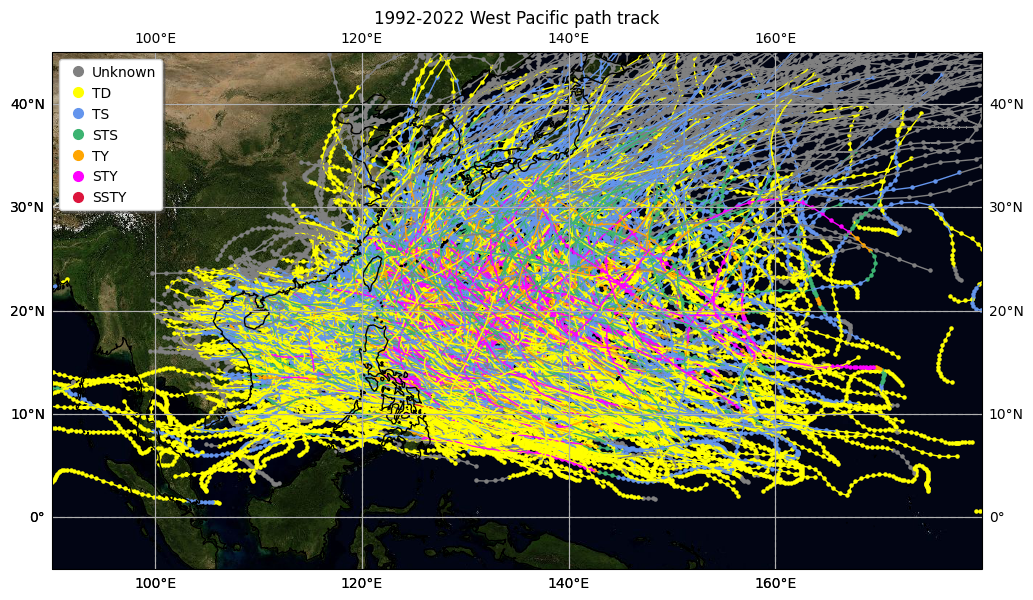

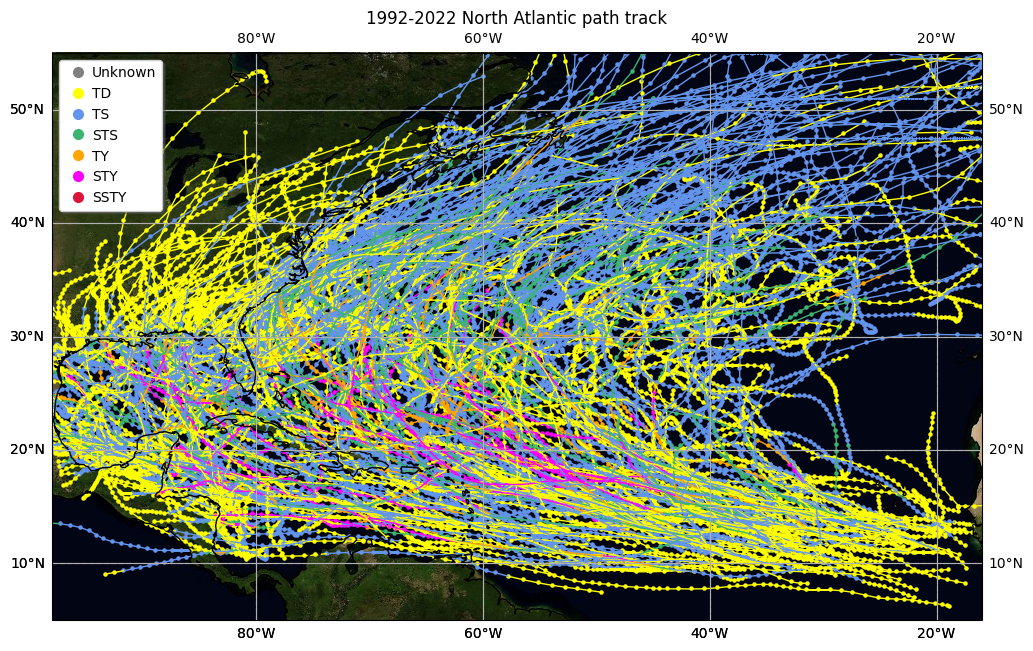

In [52]:
# Main function: User choose a function to proceed, be careful when manipulating these function, they might be detrimental.
if __name__ == '__main__':
    usi = int(input(
       "Select analytic functions here:\n1. fetch_data\n2. filter data\n3. analyze data\n4. (Experimental) typhoon map\n"))
    count = 1
    snm = dict()
    for i in range(26):
        snm[count] = chr(i+65)
        count += 1
    for i in range(26):
        for j in range(26):
            snm[count] = chr(i+65)+chr(j+65)
            count += 1
    for i in range(26):
        for j in range(26):
            for k in range(26):
                snm[count] = chr(i+65)+chr(j+65)+chr(k+65)
                count += 1
    # Please input the corresponding path for utilizing the functions
    Project_file=""
    if usi == 1:
        fetch_data()
    elif usi == 2:
        workbook = load_workbook(
            filename=Project_file)
        data_filtering("West Pacific")
        data_filtering("North Atlantic")
        workbook.save(
            Project_file)
    elif usi == 3:
        workbook = load_workbook(
            filename=Project_file)
        data_analysis("West Pacific")
        data_analysis("North Atlantic")
        workbook.save(
            Project_file)
    elif usi == 4:
        workbook = load_workbook(
            filename=Project_file)
        create_map("1992-2022 West Pacific ", "West Pacific", [90, 180, -5, 45])
        create_map("1992-2022 North Atlantic ", "North Atlantic", [262, 344, 5, 55])

In [ ]:
# Reference:
#1. "2022 Pacific typhoon season." Wikipedia. Last edited 27 November 2022. Accessed November 28, 2022. https://en.wikipedia.org/wiki/2022_Pacific_typhoon_season.
#2. "Digital Typhoon: IBTrACS Database." National Institute of Informatics (NII). Updated November 16, 2022. Accessed November 25, 2022. http://agora.ex.nii.ac.jp/digital-typhoon/ibtracs/.
#3. Hugues, Goosse. Climate System Dynamics. New York: Cambridge University Press, 2015.
#4. Jun-Wei Lin. "Web Crawler Tutorial". Accessed November 5, 2022. https://github.com/jwlin/web-crawler-tutorial/.
#5. "气象数据可视化——台风路径图." Model Whale. Updated September 23, 2020. Accessed November 27, 2022. https://www.heywhale.com/mw/project/5f48b64f5c4b5d00363819bd.
